In [1]:
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential 
from keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Dropout,Input,AveragePooling2D 
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from tensorflow.python.keras.layers import Lambda

#from tensorflow.python.keras.applications.resnet import ResNet50
from tensorflow.keras.applications import ResNet50
from keras.models import Model

%matplotlib inline
from matplotlib import pyplot as plt #untuk visualisasi data
from matplotlib import image as mpimg

from sklearn.metrics import confusion_matrix
import seaborn as sn 
import numpy as np #struktur data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [2]:
#https://www.kaggle.com/muhammadarnaldo/klasifikasi-malaria-cnn/
#https://lhncbc.nlm.nih.gov/LHC-downloads/downloads.html#malaria-datasets
import zipfile
with zipfile.ZipFile('/content/drive/MyDrive/AI/DeepLearning/cell_images.zip', 'r') as zip_ref:
    zip_ref.extractall('/content/cell_images')

In [4]:
import os
data_dir = "/content/cell_images/cell_images"
print(os.listdir(data_dir))

['Uninfected', 'Parasitized']


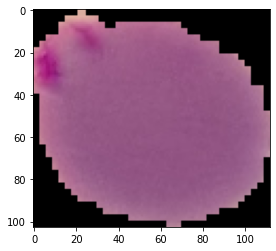

In [5]:
img_path="/content/cell_images/cell_images/Parasitized/C116P77ThinF_IMG_20150930_171739_cell_97.png" 
gambar = mpimg.imread(img_path)
plt.imshow(gambar)

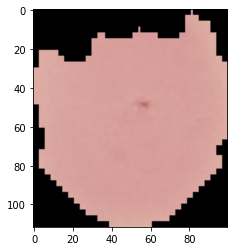

In [6]:
img_path2="/content/cell_images/cell_images/Uninfected/C100P61ThinF_IMG_20150918_144104_cell_21.png" 
gambar2 = mpimg.imread(img_path2)
plt.imshow(gambar2)

#Preprocessing

In [7]:
dim = 128
batch = 32

datagen =ImageDataGenerator(rescale=1/255.0, validation_split=0.3,
    rotation_range=20,
    zoom_range=0.05,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    horizontal_flip=True)

train_data =datagen.flow_from_directory(data_dir, target_size=(dim,dim), batch_size=batch, class_mode = 'categorical', subset = 'training')
validation_data =datagen.flow_from_directory(data_dir, target_size=(dim,dim), batch_size=batch, class_mode = 'categorical', subset = 'validation', shuffle=False)

Found 19292 images belonging to 2 classes.
Found 8266 images belonging to 2 classes.


#Create the Model

In [8]:
baseModel =ResNet50(include_top=False,input_tensor=Input(shape=(dim,dim, 3)))

headModel =baseModel.output
headModel =AveragePooling2D(pool_size=(4, 4))(headModel)
headModel =Flatten(name="flatten")(headModel)
headModel =Dense(128, activation="relu")(headModel)
headModel =Dropout(0.5)(headModel)
headModel =Dense(2, activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

model.summary()

94781440/94765736 [==============================] - 1s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization

#Training Process

In [15]:
EP = 10

model.compile(optimizer="adam",
              loss="binary_crossentropy",
              metrics=["accuracy"])

history =model.fit(train_data, validation_data=validation_data, epochs=EP)
print("*** proses training selesai ***")

Epoch 1/10
603/603 [==============================] - 152s 243ms/step - loss: 0.1648 - accuracy: 0.9503 - val_loss: 8.1747 - val_accuracy: 0.8593
Epoch 2/10
603/603 [==============================] - 144s 239ms/step - loss: 0.1453 - accuracy: 0.9536 - val_loss: 0.1503 - val_accuracy: 0.9578
Epoch 3/10
603/603 [==============================] - 144s 239ms/step - loss: 0.1308 - accuracy: 0.9578 - val_loss: 0.1255 - val_accuracy: 0.9587
Epoch 4/10
603/603 [==============================] - 144s 240ms/step - loss: 0.1328 - accuracy: 0.9581 - val_loss: 0.2418 - val_accuracy: 0.9173
Epoch 5/10
603/603 [==============================] - 144s 239ms/step - loss: 0.1232 - accuracy: 0.9596 - val_loss: 0.1214 - val_accuracy: 0.9585
Epoch 6/10
603/603 [==============================] - 145s 241ms/step - loss: 0.1260 - accuracy: 0.9584 - val_loss: 0.1338 - val_accuracy: 0.9573
Epoch 7/10
603/603 [==============================] - 145s 240ms/step - loss: 0.1172 - accuracy: 0.9616 - val_loss: 0.1480 -

#Evaluation

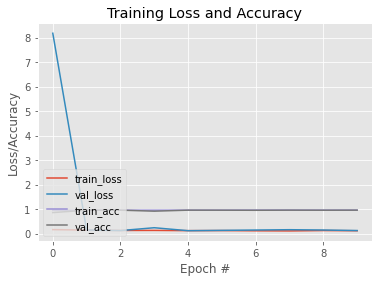

In [16]:
plt.style.use("ggplot")
plt.figure()

plt.plot(np.arange(0,EP),history.history["loss"], label="train_loss")
plt.plot(np.arange(0,EP),history.history["val_loss"], label="val_loss")
plt.plot(np.arange(0,EP),history.history["accuracy"], label="train_acc")
plt.plot(np.arange(0,EP),history.history["val_accuracy"], label="val_acc")

plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")

In [17]:
test_loss, test_acc = model.evaluate(validation_data)

259/259 [==============================] - 39s 150ms/step - loss: 0.1270 - accuracy: 0.9587


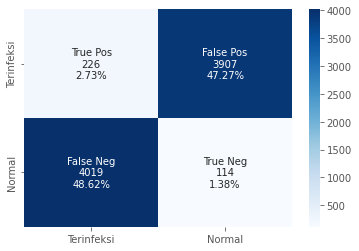

In [18]:
predictions = model.predict(validation_data)
y_pred =np.argmax(predictions, axis=-1)
y_pred = [1 * (x[0]>=0.5) for x in predictions]

cf_matrix =confusion_matrix(validation_data.classes,y_pred)

group_names = ["True Pos","False Pos","False Neg","True Neg"]
group_counts = ["{0:0.0f}".format(value) for value in cf_matrix.flatten()]
group_percentages = ["{0:.2%}".format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n{v3}" for v1,v2,v3 in zip(group_names,group_counts,group_percentages)]
labels =np.asarray(labels).reshape(2,2)

categories = ["Terinfeksi","Normal"]
sn.heatmap(cf_matrix, annot=labels, fmt='', xticklabels=categories, yticklabels=categories, cmap='Blues')

In [19]:
from sklearn.metrics import classification_report

print(classification_report(validation_data.classes,y_pred))

              precision    recall  f1-score   support

           0       0.05      0.05      0.05      4133
           1       0.03      0.03      0.03      4133

    accuracy                           0.04      8266
   macro avg       0.04      0.04      0.04      8266
weighted avg       0.04      0.04      0.04      8266

